In [1]:
import xarray as xr
import numpy as np
import glob
import pandas as pd
from datetime import datetime, timedelta
import rasterio
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from datetime import timedelta, date
from toolbox.cartopy_tools import common_features, pc  # <-- This is from https://github.com/blaylockbk/Carpenter_Workshop
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from goes2go.data import goes_nearesttime, goes_latest
from goes2go.tools import abi_crs, field_of_view
from osgeo import gdal
from pyproj import Proj, Transformer, CRS, transform
from scipy.interpolate import RegularGridInterpolator as rgi
import h5py
from mpl_toolkits.basemap import Basemap

In [2]:
hgtlvs = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400
    , 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000
    , 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 11000, 12000, 13000
    , 14000, 15000, 16000, 17000, 18000, 19000, 20000, 25000, 30000, 35000, 40000, 45000]
    
# Function that create an interpretor with an assigned parameter
def make_interpretor(ds, para=None):
    x = ds.x.values
    y = ds.y.values
    z = ds.z.values
    if not para:
        data = ds.transpose('x', 'y', 'z')
    else:
        data = ds.variables[para].transpose('x', 'y', 'z')
    interpolator = rgi(points=(x, y, z), values=data.values, method='linear', bounds_error=False)
    return interpolator

# Import function
def get_rowcol(Raster, left, bottom, right, top, xs, ys):
    with rasterio.open(Raster) as src:
        window = from_bounds(left, bottom, right, top, src.transform)
        rows, cols = rasterio.transform.rowcol(src.window_transform(window), xs, ys)
    return rows, cols
# Convert radian to cm or m
def convert_rad(data, lamda):
    result = (data * lamda) / (4 * np.pi)
    return result

# Extract value from raster and their lat/lon grid of the bounding area
def focus_bound(Raster, left, bottom, right, top):
    from rasterio.windows import Window
    from rasterio.windows import from_bounds
    with rasterio.open(Raster) as src:
        window = from_bounds(left, bottom, right, top, src.transform)
        w = src.read(1, window=window)
        aff = src.window_transform(window=window)
        X = [i * aff[0] + aff[2] for i in range(w.shape[1])]
        Y = [i * aff[4] + aff[5] for i in range(w.shape[0])]
        X, Y = np.meshgrid(X, Y)
        grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return w, grid

def Resamp_rasterio(fn: str, left, bottom, right, top, ref):
    with rasterio.open(fn) as src:
        r_height, r_width = ref.shape
        window = from_bounds(left, bottom, right, top, src.transform)
        data = src.read(out_shape=(
            src.count,
            int(r_height),
            int(r_width)),
            resampling=Resampling.nearest, window=window)
        X = np.linspace(left, right, r_width)
        Y = np.linspace(top, bottom, r_height)
        X, Y = np.meshgrid(X, Y)
        grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
        return data[0], grid

def convert_rad_degree(ds):
    # GOES-R projection info and retrieving relevant constants
    proj_info = ds.goes_imager_projection
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis

    # Data info
    lat_rad_1d = ds.variables['x'][:]
    lon_rad_1d = ds.variables['y'][:]

    # close file when finished
    # g16nc.close()
    # g16nc = None

    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin*np.pi)/180.0

    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)
    
    r_s = (-b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    return lon, lat

def extract_param_training(start_date:str, end_date:str, time:str, wm_path, dem_path, file_name, ref:str=None, batchsize=500):
    # start_date, end_date: Require string and are refering to the date range you are trying to extract. Keep the date in the format of YYYY-MM-DD (e.g. '2019-10-24')
    # time: Require string and are related to the specific UTC time HH:MM:SS (e.g.'11:00:00')
    # wm_path: The file path to all the saved weather models
    # dem_path: The file path to saved DEM
    # file name: The name to be given to the csv file will be generated.
    # ref: Require string, used when either coverage of weather model or DEM is smaller than one another. 
    def daterange(date1, date2):
        for n in range(int ((date2 - date1).days)+1):
            yield date1 + timedelta(n)
    dates = daterange(datetime.strptime(start_date, '%Y-%m-%d'),datetime.strptime(end_date, '%Y-%m-%d'))

    for i, day in enumerate(dates):
        print(day.strftime('%Y-%m-%d'))
        wm_path_ = glob.glob(wm_path+ 'ERA-5_{date}_T{time}*[A-Z].nc'.format(date=day.strftime('%Y_%m_%d'), time=time.replace(':', '_')))
        print(wm_path_)
        wm = xr.load_dataset(" ".join(wm_path_))
        if ref == 'DEM':
            with rasterio.open(dem_path) as src:
                lon_min, lon_max, lat_min, lat_max = src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top
        else:
            lon_min, lon_max, lat_min, lat_max = wm.x.values.min(), wm.x.values.max(), wm.y.values.min(), wm.y.values.max()
        print(lon_min, lon_max, lat_min, lat_max)
        # Get TPW of the day and by the hour
        try:
            tpw = goes_nearesttime(day.strftime('%Y-%m-%d') + ' ' + time, product='ABI-L2-TPW', domain='C' )
        except ValueError:
            continue
        lon, lat = convert_rad_degree(tpw)
        print(np.nanmin(lon), np.nanmax(lon),np.nanmax(lat), np.nanmin(lat))
        df = pd.DataFrame(np.hstack((lon.reshape(-1,1), lat.reshape(-1,1), (tpw.TPW*0.62).values.ravel().reshape(-1,1)))).dropna()
        df = df[(df[0]<lon_max) & (df[0]>lon_min) & (df[1]<lat_max) & (df[1]>lat_min)]
        sort_lat  = np.linspace(lat_min, lat_max, lat.shape[0])
        sort_lon = np.linspace(lon_min, lon_max, lon.shape[-1])
        if i == 0:
            with rasterio.open(dem_path) as src:
                rows, cols = rasterio.transform.rowcol(src.transform, df[0].values, df[1].values)
                hgt_m = src.read(1)[rows, cols]
                # hgt_m[np.isnan(hgt_m)] = 0.0
        else:
            pass
        
        # xarray interp function can not perform on non regular grid coordinates.
        # The only option of interp with given lat lon to create a arbitary grid in batches then extract the diagonal of the data.
        wm_param = []
        batchsize = batchsize
        for iter in range(0, len(df), batchsize):
            x = df[0].iloc[iter:iter+batchsize]
            y = df[1].iloc[iter:iter+batchsize]
            # print(x, y)
            p = wm.p.interp(x=x, y=y, z=hgtlvs).values.transpose().diagonal().transpose()
            t = wm.t.interp(x=x, y=y, z=hgtlvs).values.transpose().diagonal().transpose()
            e = wm.e.interp(x=x, y=y, z=hgtlvs).values.transpose().diagonal().transpose()
            wm_param.append(np.hstack((p,t,e)))
        wm_param = np.vstack(wm_param)
        acq_date = np.array([day.strftime('%Y-%m-%d')] * int(len(df))).reshape(-1, 1)
        df = pd.concat((pd.DataFrame(acq_date).reset_index(drop=True), df.reset_index(drop=True), pd.DataFrame(hgt_m.reshape(-1,1)).reset_index(drop=True), pd.DataFrame(wm_param).reset_index(drop=True)),axis=1)

        if i == 0:
            df.columns = ['Date', 'Lon', 'Lat', 'PWV', 'Hgt_m'] + ['P_' + str(i) for i in range(len(hgtlvs))] + ['T_' + str(i) for i in range(len(hgtlvs))] +['e_' + str(i) for i in range(len(hgtlvs))]
            df.to_csv(file_name + '_PTE_PWV.csv', index=False)
        else:
            df.to_csv(file_name + '_PTE_PWV.csv', index=False, mode='a', header=False)
        print('Finished')

# Get Interferogram in California

## Date 20210828_20210822

In [3]:
dataset = rasterio.open('InSAR/Large_scale/West/Extracted/unwrappedPhase/20210828_20210822')
ifg = dataset.read(1)
ifg[ifg==0] = np.nan
ifg = (ifg * 5.6) / (4*np.pi)

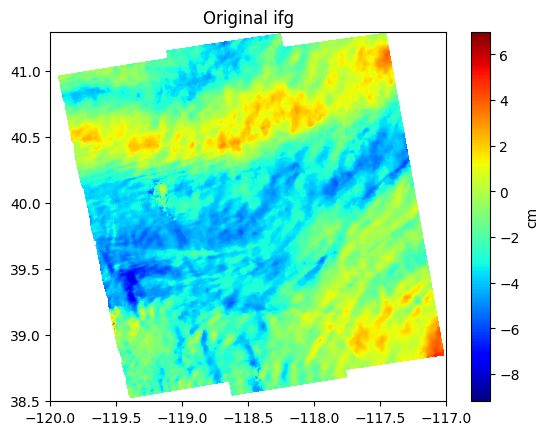

In [4]:
plt.imshow(ifg - ifg[2100, 3100], extent=[-120, -117, 38.5, 41.3], cmap='jet')
plt.colorbar(label='cm')
plt.title('Original ifg')
plt.show()

## Date 20210915_20210909

In [49]:
dataset = rasterio.open('InSAR/Large_scale/West/Extracted/unwrappedPhase/20210915_20210909')
ifg = dataset.read(1)
ifg[ifg==0] = np.nan
ifg = (ifg * 5.6) / (4*np.pi)

In [50]:
dataset.xy(2100,3100)

(-117.977916666666, 39.59041666666668)

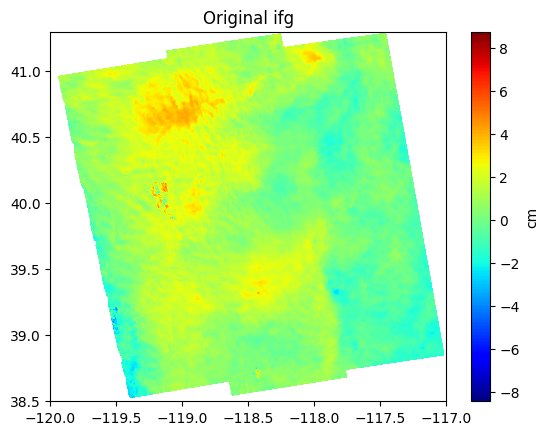

In [51]:
plt.imshow(ifg - ifg[2100, 3100], extent=[-120, -117, 38.5, 41.3], cmap='jet')
plt.colorbar(label='cm')
plt.title('Original ifg')
plt.show()

In [5]:
DEM = rasterio.open('InSAR/Large_scale/West/Extracted/DEM/SRTM_3arcsec_uncropped.tif')
dem = DEM.read(1)
dem[dem<=0.0] = np.nan

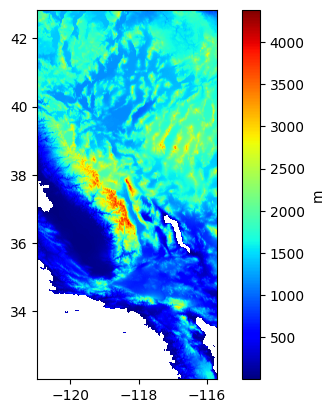

In [6]:
plt.imshow(dem, cmap='jet', extent=[-120.964,-115.713,32.0157, 42.836])
plt.colorbar(label='m')
plt.show()

# Download and get GOES data by date and time

BoundingBox(left=-120.561666666666, bottom=38.4916666666667, right=-117.044166666666, top=41.3408333333333)

In [5]:
def radian2degree(ds):
    # Satellite height
    sat_h = ds.goes_imager_projection.perspective_point_height

    # Satellite longitude
    sat_lon = ds.goes_imager_projection.longitude_of_projection_origin
    sat_lat = ds.goes_imager_projection.latitude_of_projection_origin

    # Satellite sweep
    sat_sweep = ds.goes_imager_projection.sweep_angle_axis

    # The projection x and y coordinates equals
    # the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
    X = ds.x * sat_h
    Y = ds.y * sat_h
    # map object with pyproj
    p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
    # Convert map points to latitude and longitude with the magic provided by Pyproj
    XX, YY = np.meshgrid(X, Y)
    lons, lats = p(XX, YY, inverse=True)
    return lons, lats

In [7]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

## Date 20210828_20210822

In [3]:
ds1 = goes_nearesttime('2021-08-22 01:50', product='ABI-L2-TPW', domain='C', satellite=17)
ds2 = goes_nearesttime('2021-08-28 01:50', product='ABI-L2-TPW', domain='C', satellite=17)

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes17/ABI-L2-TPWC/2021/234/01/OR_ABI-L2-TPWC-M6_G17_s20212340151177_e20212340153549_c20212340155115.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes17/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes17/ABI-L2-TPWC/2021/240/01/OR_ABI-L2-TPWC-M6_G17_s20212400151177_e20212400153550_c20212400155213.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes17/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [8]:
crs, x, y = abi_crs(ds1, 'TPW')

Text(0.5, 1.0, '01:52 UTC 22 Aug 2021')

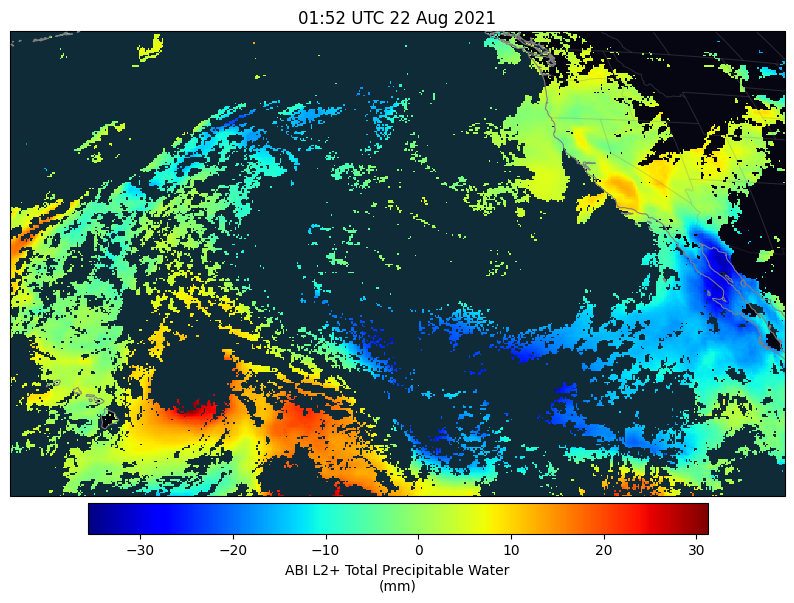

In [9]:
ax = common_features('50m', crs=ds1.FOV.crs, figsize=[10,8], dark=True).STATES().OCEAN().LAND().ax
c = ax.pcolormesh(x, y, ds1.TPW- ds2.TPW, transform=ds1.FOV.crs, cmap='jet')
plt.colorbar(c, ax=ax, shrink=.8, pad=.01, orientation='horizontal', label=f"{ds1.TPW.long_name}\n({ds1.TPW.units})")
ax.set_title(f"{ds1.t.dt.strftime('%H:%M UTC %d %b %Y').item()}")

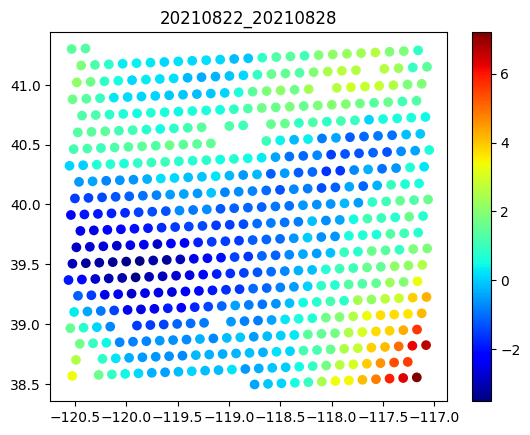

In [8]:
DS1 = calc_latlon(ds1)
DS2 = calc_latlon(ds2)
tpw1 = DS1.where((DS1.lon < -117.044) & (DS1.lon > -120.562) & (DS1.lat > 38.492) & (DS1.lat < 41.3048))
tpw2 = DS2.where((DS2.lon < -117.044) & (DS2.lon > -120.562) & (DS2.lat > 38.492) & (DS2.lat < 41.3048))
plt.scatter(tpw1.lon.values, tpw1.lat.values, c=(tpw1.TPW.values - tpw2.TPW.values), cmap='jet')
plt.title('20210822_20210828')
plt.colorbar()
plt.show()

/tmp/ipykernel_5449/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


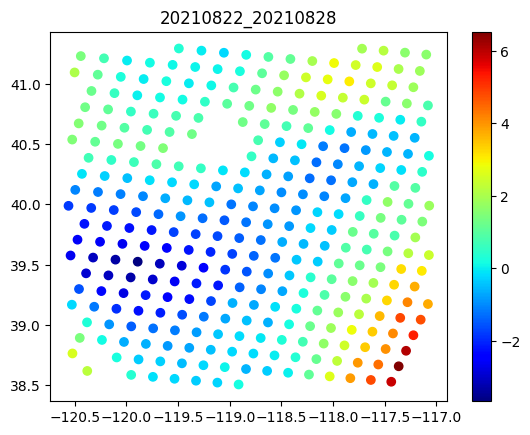

In [12]:
DS1 = calc_latlon(ds1)
DS2 = calc_latlon(ds2)
tpw1 = DS1.where((DS1.lon < -117.044) & (DS1.lon > -120.562) & (DS1.lat > 38.492) & (DS1.lat < 41.3048))
tpw2 = DS2.where((DS2.lon < -117.044) & (DS2.lon > -120.562) & (DS2.lat > 38.492) & (DS2.lat < 41.3048))
plt.scatter(tpw1.lon.values, tpw1.lat.values, c=(tpw1.TPW.values - tpw2.TPW.values), cmap='jet')
plt.title('20210822_20210828')
plt.colorbar()
plt.show()

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 5.250361001197223
Full Sill: 5.255735903928637
Range: 3.731183219422275
Nugget: 0.005374902731414569 



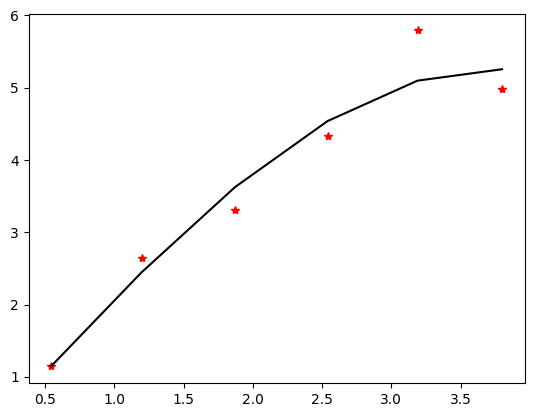

Calculating statistics on variogram model fit...


In [15]:
# Import Library
from pykrige.ok import OrdinaryKriging
clean_tpw = pd.DataFrame(np.hstack((tpw1.lon.values.ravel().reshape(-1,1), tpw1.lat.values.ravel().reshape(-1,1), (tpw1.TPW.values - tpw2.TPW.values).ravel().reshape(-1,1)))).dropna()
x = clean_tpw[0]
y = clean_tpw[1]
val = clean_tpw[2]
OK = OrdinaryKriging(x, y, val, variogram_model = 'spherical', verbose=True, enable_plotting=True)

In [16]:
gridx = np.linspace(-120.561666666666, -117.044166666666, 400)
gridy = np.linspace(38.4916666666667, 41.3408333333333 , 300)
estimate, ss = OK.execute('grid', gridx, gridy)

Executing Ordinary Kriging...



In [20]:
aff = dataset.transform
X = [i * aff[0] + aff[2] for i in range(ifg.shape[1])]
Y = [i * aff[4] + aff[5] for i in range(ifg.shape[0])]
X, Y = np.meshgrid(X, Y)
grid = np.stack([Y.ravel(), X.ravel()], axis=-1)

In [15]:
x = (list(set(grid[:, 0])))
x.sort()

In [154]:
TPW_interp = rgi(points=(gridy, gridx), values=estimate.data, bounds_error=False)(grid)
TPW_interp = TPW_interp.reshape(ifg.shape)

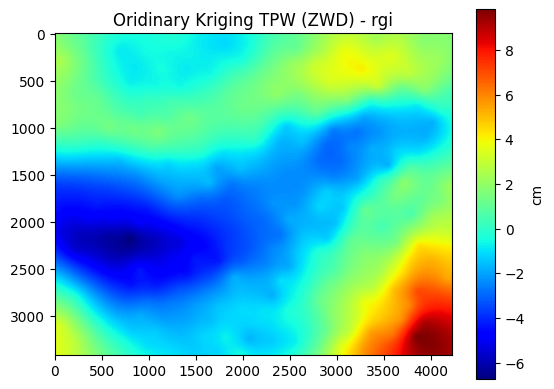

In [161]:
plt.imshow((TPW_interp - TPW_interp[2100, 3100])*1.62, cmap='jet')
plt.colorbar(label='cm')
plt.title('Oridinary Kriging TPW (ZWD) - rgi')
plt.show()

In [186]:
np.nanmean((ifg-ifg[2100,3100])/(TPW_interp - TPW_interp[2100, 3100]))

/tmp/ipykernel_36342/1642865706.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmean((ifg-ifg[2100,3100])/(TPW_interp - TPW_interp[2100, 3100]))


1.2244215349029774

In [104]:
# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

In [105]:
a,b = best_fit((ifg - ifg[2100, 3100])[~np.isnan(ifg)].ravel() , ((TPW_interp - TPW_interp[2100, 3100]))[~np.isnan(ifg)].ravel())
a,b

best fit line:
y = 0.76 + 0.61x


(0.7558664142012045, 0.6130815712127184)

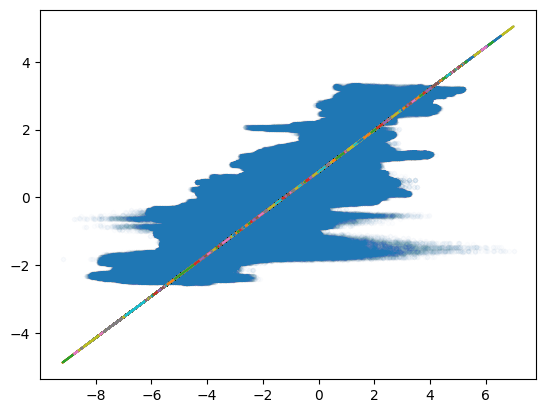

In [111]:
plt.scatter(ifg - ifg[2100, 3100] , ((TPW_interp - TPW_interp[2100, 3100])*0.61), marker='.', alpha=0.01)
yfit = [a + b * xi for xi in ifg - ifg[2100, 3100]]
plt.plot(ifg - ifg[2100, 3100], yfit)
plt.show()

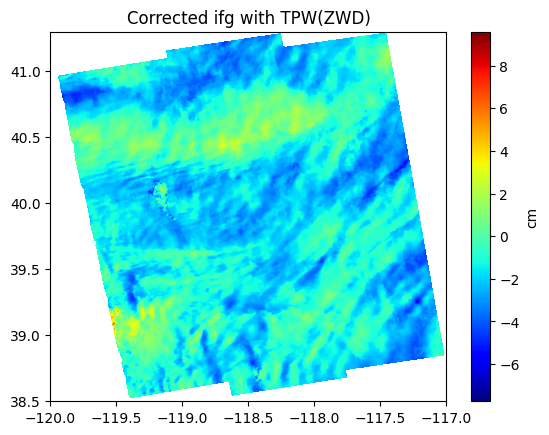

In [185]:
plt.imshow((ifg - ifg[2100, 3100] - ((TPW_interp - TPW_interp[2100, 3100]))), cmap='jet',extent=[-120, -117, 38.5, 41.3])
plt.colorbar(label='cm')
plt.title('Corrected ifg with TPW(ZWD)')
plt.show()

In [184]:
# Original ifg std
og_std = np.nanstd(ifg-ifg[2100, 3100])
# TPW corrected ifg std
TPW_corr_std = np.nanstd(ifg - ifg[2100, 3100] - ((TPW_interp - TPW_interp[2100, 3100])))
# Percentage chage
per_change = (TPW_corr_std - og_std)/og_std
print('Metric compare')
print('Orgin ifg std: ', og_std)
print('TPW corrected ifg std: ', TPW_corr_std)
print('Percentage change: ', per_change)

Metric compare
Orgin ifg std:  2.0001204
TPW corrected ifg std:  1.2608473275969998
Percentage change:  -0.36961428585722866


## RAiDER corrrection

In [5]:
dem = 'InSAR/Large_scale/West/Extracted/DEM/SRTM_3arcsec_uncropped.tif'
wm1 = 'InSAR/Large_scale/West/weather_files/ERA-5_2021_08_22_T02_00_00_27N_47N_126W_112W.nc'
wm2 = 'InSAR/Large_scale/West/weather_files/ERA-5_2021_08_28_T02_00_00_27N_47N_126W_112W.nc'
WM1 = xr.load_dataset(wm1)
WM2 = xr.load_dataset(wm2)
DEM, grid = Resamp_rasterio(dem, left=-120.561666666666, bottom=38.4916666666667, right=-117.044166666666, top=41.3408333333333, ref=ifg)

In [9]:
aff = dataset.transform
X = [i * aff[0] + aff[2] for i in range(ifg.shape[1])]
Y = [i * aff[4] + aff[5] for i in range(ifg.shape[0])]

In [7]:
WM1

<xarray.Dataset>
Dimensions:      (x: 56, y: 82, z: 38)
Coordinates:
  * x            (x) float64 -125.4 -125.2 -124.9 ... -112.2 -111.9 -111.7
  * y            (y) float64 26.1 26.35 26.6 26.85 ... 45.6 45.85 46.1 46.35
  * z            (z) float32 -100.0 60.6 277.8 ... 4.018e+04 4.324e+04 4.863e+04
Data variables:
    WGS84        |S1 b''
    latitude     (z, y, x) float64 38.32 38.32 38.32 38.32 ... 46.35 46.35 46.35
    longitude    (z, y, x) float64 -116.0 -116.0 -116.0 ... -112.2 -111.9 -111.7
    t            (z, y, x) float32 290.8 290.8 290.9 291.0 ... 262.8 262.9 262.8
    p            (z, y, x) float32 9.777e+04 9.777e+04 9.776e+04 ... 104.6 104.6
    e            (z, y, x) float32 1.756e+03 1.759e+03 ... -0.0009461 -0.0009381
    wet          (z, y, x) float32 79.27 79.4 77.33 ... -5.219e-05 -5.177e-05
    hydro        (z, y, x) float32 260.9 260.9 260.8 ... 0.3087 0.3087 0.3089
    wet_total    (z, y, x) float32 0.1366 0.1369 0.1356 0.134 ... 0.0 0.0 0.0
    hydro_total  (z, y, x) float32 2.336 2.336 2.336 2.336 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:   CF-1.6
    datetime:      2021_08_22T02_00_00
    date_created:  2022_08_12T02_57_05
    title:         Weather model data and delay calculations

In [16]:
Lon = np.linspace(WM1.x.values[0], WM1.x.values[-1], 30)
Lat = np.linspace(WM1.y.values[-1], WM1.y.values[0], 50)

In [17]:
WM_ = WM1.interp(x = Lon, y = Lat, z= hgtlvs)

In [19]:
WM_

<xarray.Dataset>
Dimensions:      (z: 51, y: 50, x: 30)
Coordinates:
  * x            (x) float64 -125.4 -124.9 -124.5 ... -112.6 -112.1 -111.7
  * y            (y) float64 46.35 45.94 45.52 45.11 ... 27.34 26.93 26.51 26.1
  * z            (z) int64 0 200 400 600 800 ... 25000 30000 35000 40000 45000
Data variables:
    WGS84        |S1 b''
    latitude     (z, y, x) float64 -2.119e+38 -2.119e+38 ... -1.109e+38
    longitude    (z, y, x) float64 -2.119e+38 -2.119e+38 ... -1.109e+38
    t            (z, y, x) float64 286.1 285.8 285.3 285.5 ... 260.6 261.0 260.8
    p            (z, y, x) float64 9.798e+04 9.796e+04 9.795e+04 ... 196.5 196.4
    e            (z, y, x) float64 1.347e+03 1.359e+03 ... -0.0001448 -0.0001181
    wet          (z, y, x) float64 62.81 63.51 64.28 ... -8.1e-06 -6.619e-06
    hydro        (z, y, x) float64 265.8 266.0 266.4 ... 0.5852 0.584 0.5845
    wet_total    (z, y, x) float64 0.1407 0.1452 0.1491 ... -2.94e-08 -2.402e-08
    hydro_total  (z, y, x) float64 2.312 2.311 2.311 ... 0.00212 0.002121
Attributes:
    Conventions:   CF-1.6
    datetime:      2021_08_22T02_00_00
    date_created:  2022_08_12T02_57_05
    title:         Weather model data and delay calculations

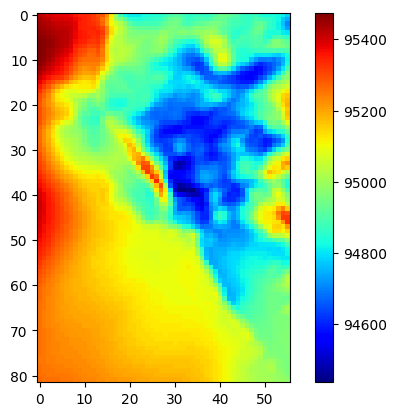

In [32]:
plt.imshow(np.flipud(WM1.p[3].values), cmap='jet')
plt.colorbar()
plt.show()

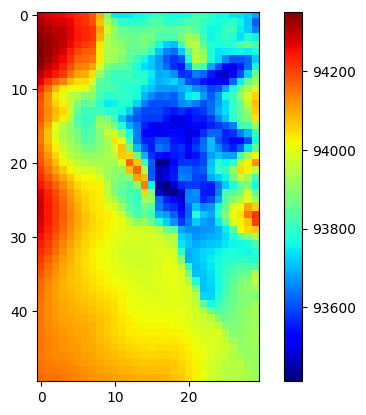

In [18]:
plt.imshow(WM_.p[3].values, cmap='jet')
plt.colorbar()
plt.show()

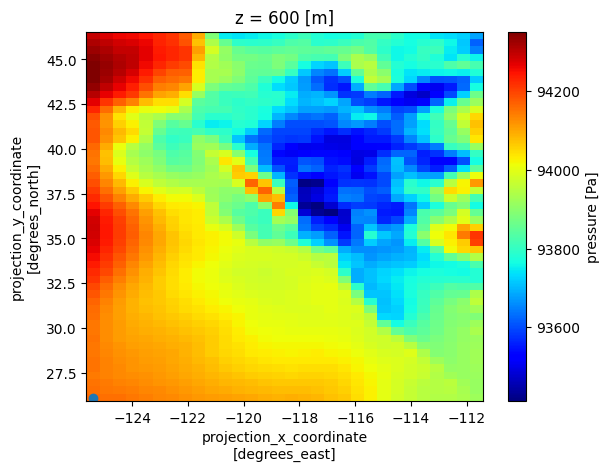

In [15]:
WM_.p[3].plot(cmap='jet')
plt.scatter(WM1.longitude[3][0,0], WM1.latitude[3][0,0])
plt.show()

In [19]:
WM1.p.interp(x=WM1.longitude.values[3,25,25], y = WM1.latitude.values[3,25,25], z=500.29547).values

array(95089.04688854)

In [7]:
WM1.p.interp(x=-123.900002, y =33.349998).values

array([97781.65626651, 97781.65626651, 97781.65626651, 95240.90626622,
       92690.10939102, 90139.90628   , 87636.51564096, 85126.75784075,
       82617.97657755, 80106.03127707, 77603.42971441, 75108.67188912,
       70129.97659926, 65169.00782586, 60205.97266827, 55237.61329269,
       50269.71876078, 45283.59375207, 40273.54687667, 35261.88282095,
       30239.79688315, 25220.37500735, 22704.51173457, 20198.17384341,
       17679.16602953, 15153.54103144, 12610.42188595, 10054.34375652,
        7016.66162022,  4997.54931518,  2994.25683418,  1995.44616661,
         996.23034597,   698.20245289,   497.56661956,   297.02676355,
         198.07800272,   198.07800272])

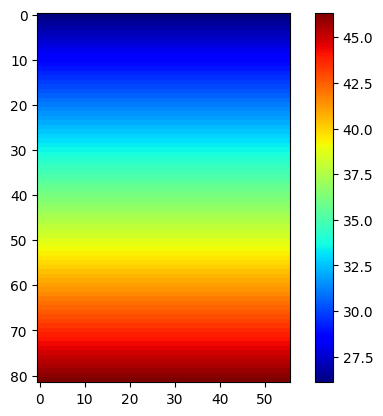

In [15]:
plt.imshow(WM1.latitude.values[3,:,:], cmap='jet')
plt.colorbar()
plt.show()

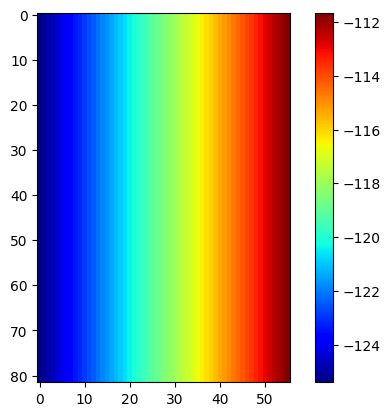

In [16]:
plt.imshow(WM1.longitude.values[3,:,:], cmap='jet')
plt.colorbar()
plt.show()

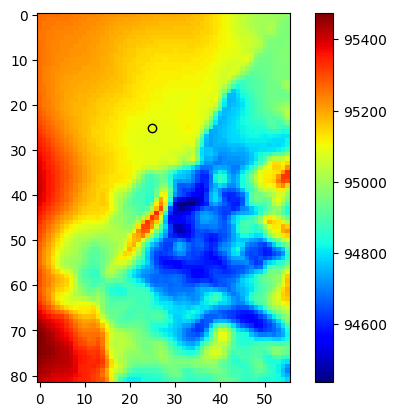

In [17]:
plt.imshow(WM1.p.values[3,:,:], cmap='jet')
plt.colorbar()
plt.scatter(25,25,c=WM1.p.interp(x=WM1.longitude.values[3,25,25], y = WM1.latitude.values[3,25,25], z=500.29547), vmin= WM1.p.values[3,:,:].min(), vmax = WM1.p.values[3,:,:].max(), cmap='jet', edgecolors='black')
plt.show()

In [9]:
WM1.longitude.values[3,25,25], WM1.latitude.values[3,25,25]

(-119.1500015258789, 32.349998474121094)

In [ ]:
WM1.p.interp

In [12]:
WM1.p.values.T[7,29,:]

array([97773.05   , 97773.05   , 97773.05   , 95224.77   , 92673.555  ,
       90131.414  , 87621.51   , 85111.79   , 82603.445  , 80091.87   ,
       77589.695  , 75095.34   , 70123.445  , 65157.18   , 60194.695  ,
       55232.094  , 50264.824  , 45279.07   , 40269.395  , 35258.113  ,
       30239.635  , 25220.375  , 22704.512  , 20198.174  , 17679.166  ,
       15153.541  , 12610.422  , 10055.694  ,  7016.6675 ,  4997.55   ,
        2994.537  ,  1995.4462 ,   996.22925,   698.13983,   497.56662,
         297.02676,   198.078  ,   198.078  ], dtype=float32)

In [19]:
    # Get all the x,y coordinate
    x = list(set(grid[:, 1]))
    x.sort()
    y = list(set(grid[:, 0]))
    y.sort()

    # Day1 WM (PTe) parameters
    P1 = WM1.p.interp(x=x, y=y, z=hgtlvs).values
    # T1 = wm1.t.interp(x=x, y=y, z=hgtlvs).values
    # e1 = wm1.e.interp(x=x, y=y, z=hgtlvs).values

In [20]:
P1

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [123]:
loc = np.hstack((grid, DEM.ravel().reshape(-1,1)))

In [124]:
hydro_interp_1, wet_interp_1, hydro_interp_2, wet_interp_2 = make_interpretor(WM1, 'hydro_total'), make_interpretor(WM1, 'wet_total'), make_interpretor(WM2, 'hydro_total'), make_interpretor(WM2, 'wet_total')
hydro_1, wet_1, hydro_2, wet_2 = hydro_interp_1(loc), wet_interp_1(loc), hydro_interp_2(loc), wet_interp_2(loc)
TD = (hydro_1 + wet_1) - (hydro_2 + wet_2)
HTD = hydro_1 - hydro_2
TD = TD.reshape(DEM.shape)
HTD = HTD.reshape(DEM.shape)

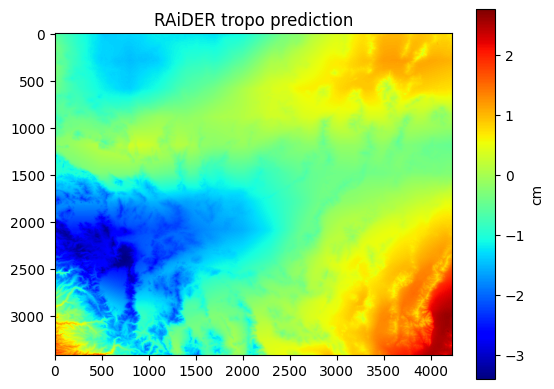

In [125]:
plt.imshow((TD - TD[2100,3100])*100, cmap='jet')
plt.colorbar(label='cm')
plt.title('RAiDER tropo prediction')
plt.show()

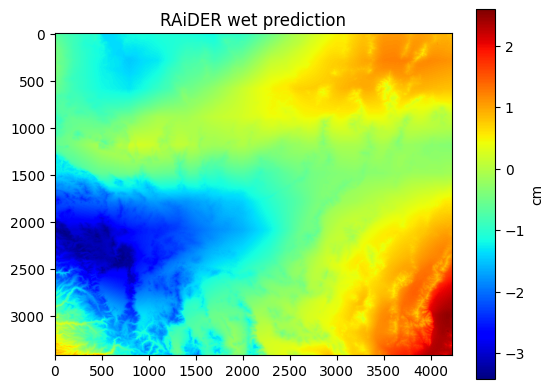

In [139]:
plt.imshow(((wet_1- wet_2).reshape(ifg.shape) - (wet_1-wet_2).reshape(ifg.shape)[2100,3100])*100, cmap='jet')
plt.colorbar(label='cm')
plt.title('RAiDER wet prediction')
plt.show()

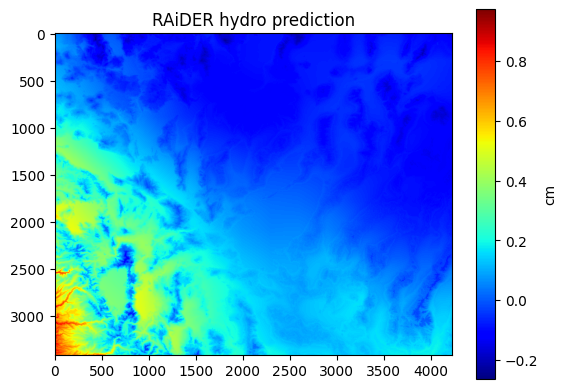

In [137]:
plt.imshow((HTD - HTD[2100,3100])*100, cmap='jet')
plt.colorbar(label='cm')
plt.title('RAiDER hydro prediction')
plt.show()

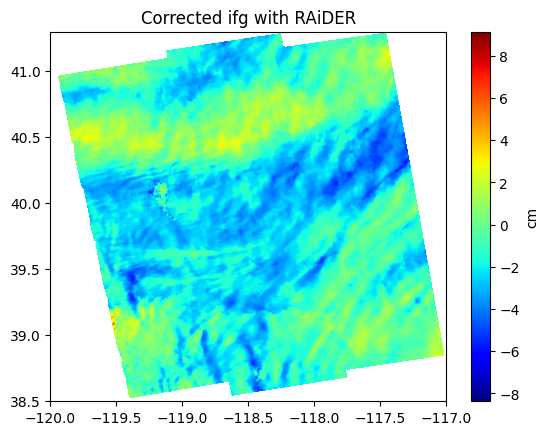

In [145]:
plt.imshow(ifg - ifg[2100, 3100] - (TD - TD[2100, 3100])*100, cmap='jet',extent=[-120, -117, 38.5, 41.3])
plt.colorbar(label='cm')
plt.title('Corrected ifg with RAiDER')
plt.show()

In [146]:
# Original ifg std
og_std = np.nanstd(ifg-ifg[2100, 3100])
# TPW corrected ifg std
TD_corr_std = np.nanstd((ifg - ifg[2100, 3100])- ((TD - TD[2100, 3100])*100))
# Percentage chage
per_change = (TD_corr_std - og_std)/og_std
print('Metric compare')
print('Orgin ifg std: ', og_std)
print('Raider corrected ifg std: ', TD_corr_std)
print('Percentage change: ', per_change)

Metric compare
Orgin ifg std:  2.0001204
Raider corrected ifg std:  1.5334616710332278
Percentage change:  -0.23331531943110653


## Date 202100915_20210909

In [52]:
ds1 = goes_nearesttime('2021-09-09 01:50', product='ABI-L2-TPW', domain='C')
ds2 = goes_nearesttime('2021-09-15 01:50', product='ABI-L2-TPW', domain='C')

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2021/252/01/OR_ABI-L2-TPWC-M6_G16_s20212520151190_e20212520153563_c20212520155167.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/home/nyv62/miniconda3/envs/goes2go/lib/python3.9/site-packages/goes2go/data.py:155: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  product_mode = df.product_mode.str.rsplit("-", 1, expand=True)


 👮🏻‍♂️ File already exists. Do not overwrite: /mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC/2021/258/01/OR_ABI-L2-TPWC-M6_G16_s20212580151192_e20212580153565_c20212580155181.nc
📦 Finished downloading [1] files to [/mnt/stor/geob/jlmd9g/Kenny/GOES_data/data/noaa-goes16/ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [53]:
crs, x, y = abi_crs(ds1, 'TPW')

Text(0.5, 1.0, '01:52 UTC 09 Sep 2021')

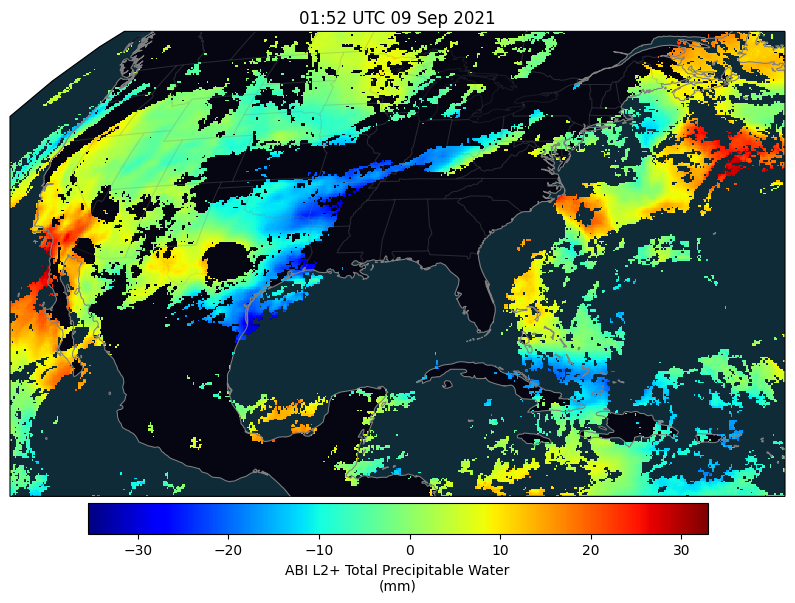

In [90]:
ax = common_features('50m', crs=ds1.FOV.crs, figsize=[10,8], dark=True).STATES().OCEAN().LAND().ax
c = ax.pcolormesh(x, y, ds1.TPW- ds2.TPW, transform=ds1.FOV.crs, cmap='jet')
plt.colorbar(c, ax=ax, shrink=.8, pad=.01, orientation='horizontal', label=f"{ds1.TPW.long_name}\n({ds1.TPW.units})")
ax.set_title(f"{ds1.t.dt.strftime('%H:%M UTC %d %b %Y').item()}")

/tmp/ipykernel_36342/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


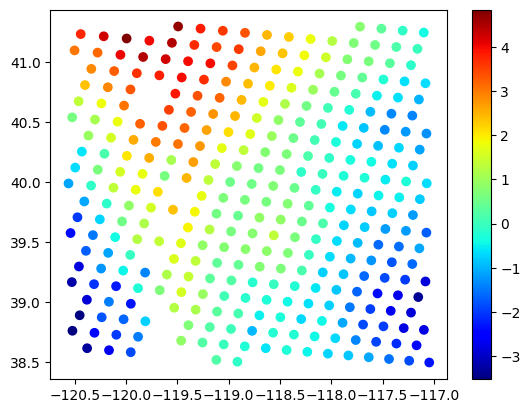

In [84]:
DS1 = calc_latlon(ds1)
DS2 = calc_latlon(ds2)
tpw1 = DS1.where((DS1.lon < -117.044) & (DS1.lon > -120.562) & (DS1.lat > 38.492) & (DS1.lat < 41.3048))
tpw2 = DS2.where((DS2.lon < -117.044) & (DS2.lon > -120.562) & (DS2.lat > 38.492) & (DS2.lat < 41.3048))
plt.scatter(tpw1.lon.values, tpw1.lat.values, c=(tpw1.TPW.values - tpw2.TPW.values)-5, cmap='jet')
plt.colorbar()
plt.show()

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 6.109658029552617
Full Sill: 6.10965802955417
Range: 3.8237572132416924
Nugget: 1.5531228981994348e-12 



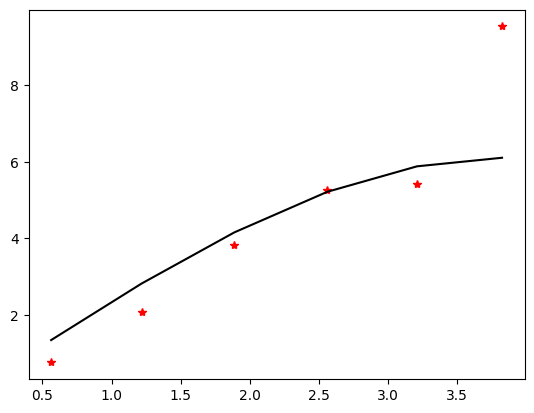

Calculating statistics on variogram model fit...


In [70]:
# Import Library
from pykrige.ok import OrdinaryKriging
clean_tpw = pd.DataFrame(np.hstack((tpw1.lon.values.reshape(-1,1), tpw1.lat.values.reshape(-1,1), (tpw1.TPW.values - tpw2.TPW.values).ravel().reshape(-1,1)))).dropna()
x = clean_tpw[0]
y = clean_tpw[1]
val = clean_tpw[2]
OK = OrdinaryKriging(x, y, val, variogram_model = 'spherical', verbose=True, enable_plotting=True)

In [71]:
gridx = np.linspace(-120.561666666666, -117.044166666666, 400)
gridy = np.linspace(38.4916666666667, 41.3408333333333 , 300)
estimate, ss = OK.execute('grid', gridx, gridy)

Executing Ordinary Kriging...



In [72]:
aff = dataset.transform
X = [i * aff[0] + aff[2] for i in range(ifg.shape[1])]
Y = [i * aff[4] + aff[5] for i in range(ifg.shape[0])]
X, Y = np.meshgrid(X, Y)
grid = np.stack([Y.ravel(), X.ravel()], axis=-1)

In [73]:
TPW_interp = rgi(points=(gridy, gridx), values=estimate.data, bounds_error=False)(grid)
TPW_interp = TPW_interp.reshape(ifg.shape)

In [74]:
a,b = best_fit((ifg - ifg[2100, 3100])[~np.isnan(ifg)].ravel() , ((TPW_interp - TPW_interp[2100, 3100]))[~np.isnan(ifg)].ravel())

best fit line:
y = 0.50 + 1.01x


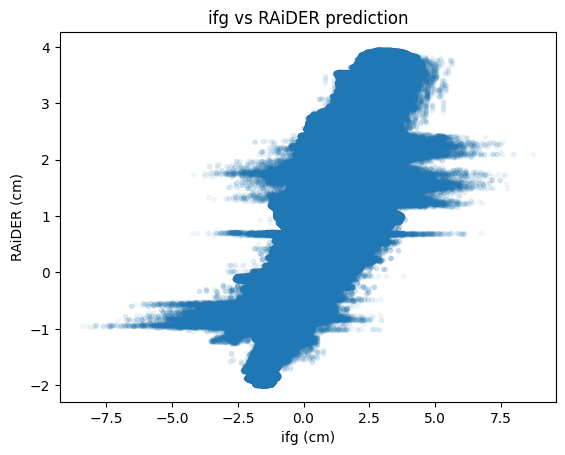

In [74]:
plt.scatter((ifg - ifg[2100,3100]), ((TD - TD[2100,3100])*100).ravel(), marker='.', alpha=0.05)
plt.xlabel('ifg (cm)')
plt.ylabel('RAiDER (cm)')
plt.title('ifg vs RAiDER prediction')
plt.show()

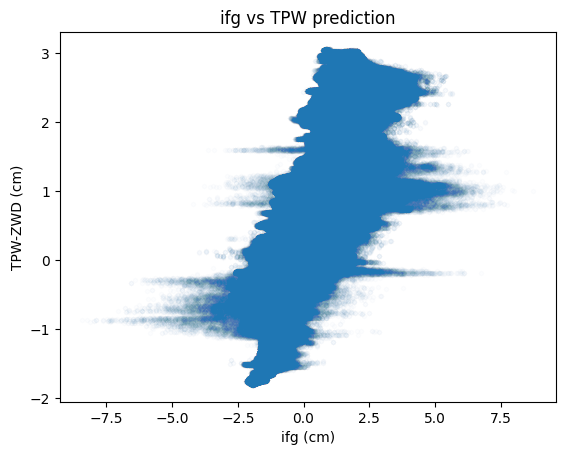

In [89]:
plt.scatter((ifg - ifg[2100, 3100]).ravel(),(((TPW_interp - TPW_interp[2100,3100])*0.62)).ravel(), marker='.', alpha=0.01)
plt.xlabel('ifg (cm)')
plt.ylabel('TPW-ZWD (cm)')
plt.title('ifg vs TPW prediction')
plt.show()

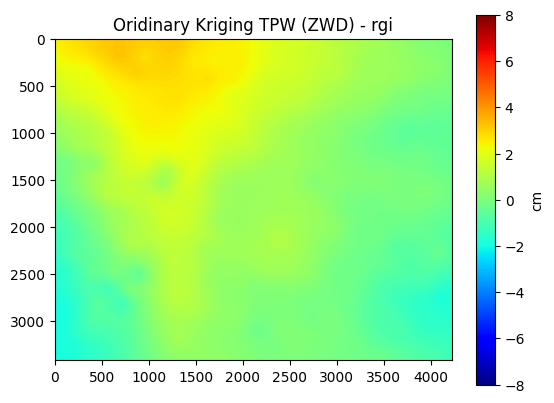

In [90]:
plt.imshow((TPW_interp - TPW_interp[2100, 3100])*0.62, cmap='jet', vmin=-8, vmax=8)
plt.colorbar(label='cm')
plt.title('Oridinary Kriging TPW (ZWD) - rgi')
plt.show()

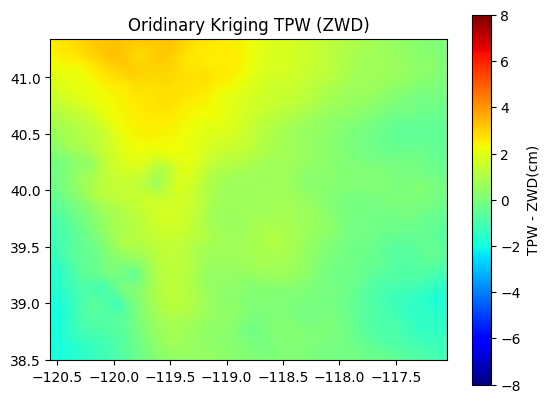

In [106]:
plt.imshow(np.flipud((estimate - 4.5)*0.62), cmap='jet', vmin=-8, vmax=8, extent=[-120.56, -117.0442, 38.492, 41.341])
plt.colorbar(label='TPW - ZWD(cm)')
plt.title('Oridinary Kriging TPW (ZWD)')
plt.show()

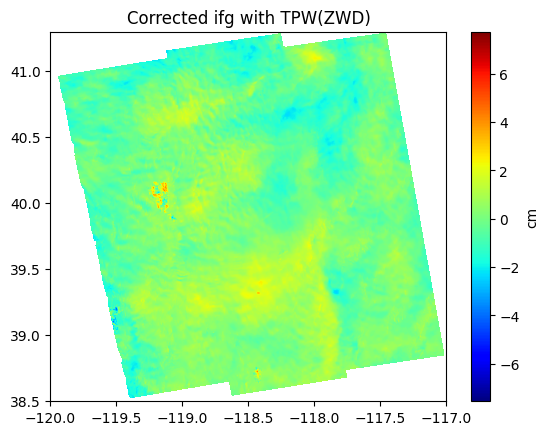

In [91]:
plt.imshow(ifg - ifg[2100, 3100] - ((TPW_interp - TPW_interp[2100, 3100])*0.62), cmap='jet',extent=[-120, -117, 38.5, 41.3])
plt.colorbar(label='cm')
plt.title('Corrected ifg with TPW(ZWD)')
plt.show()

In [92]:
# Original ifg std
og_std = np.nanstd(ifg-ifg[2100, 3100])
# TPW corrected ifg std
TPW_corr_std = np.nanstd(ifg - ifg[2100, 3100] - ((TPW_interp - TPW_interp[2100, 3100])*0.62))
# Percentage chage
per_change = (TPW_corr_std - og_std)/og_std
print('Metric compare')
print('Orgin ifg std: ', og_std)
print('Raider corrected ifg std: ', TPW_corr_std)
print('Percentage change: ', per_change)

Metric compare
Orgin ifg std:  1.1567755
Raider corrected ifg std:  0.7717981427914419
Percentage change:  -0.3328021212648992


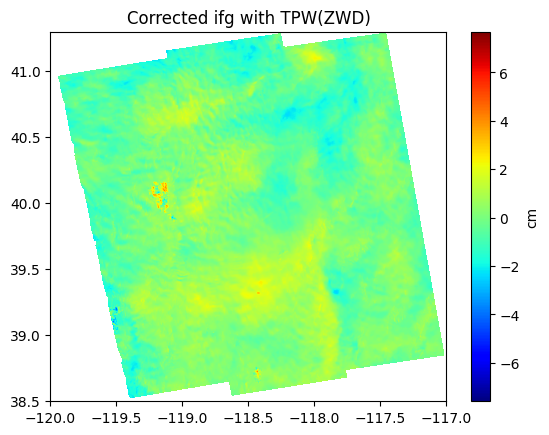

In [114]:
plt.imshow(ifg - ifg[2100, 3100] - np.flipud((estimate - 4.5)*0.62), cmap='jet',extent=[-120, -117, 38.5, 41.3])
plt.colorbar(label='cm')
plt.title('Corrected ifg with TPW(ZWD)')
plt.show()

In [117]:
# Corrected ifg std
np.nanstd((ifg - ifg[2100, 3100]) - np.flipud((estimate - 4.5)*0.62))

0.7722304089515412

In [118]:
# Percentage change
(np.nanstd((ifg - ifg[2100, 3100]) - np.flipud((estimate - 4.5)*0.62)) - np.nanstd(ifg - ifg[2100, 3100]))/np.nanstd(ifg - ifg[2100, 3100])

-0.33242843927594795

# RAiDER Tropo correction comparison

In [4]:
dataset.bounds

BoundingBox(left=-120.561666666666, bottom=38.4916666666667, right=-117.044166666666, top=41.3408333333333)

In [44]:
dem = 'InSAR/Large_scale/West/Extracted/DEM/SRTM_3arcsec_uncropped.tif'
wm1 = 'InSAR/Large_scale/West/weather_files/ERA-5_2021_09_09_T02_00_00_27N_47N_126W_112W.nc'
wm2 = 'InSAR/Large_scale/West/weather_files/ERA-5_2021_09_15_T02_00_00_27N_47N_126W_112W.nc'
WM1 = xr.load_dataset(wm1)
WM2 = xr.load_dataset(wm2)
DEM, grid = Resamp_rasterio(dem, left=-120.561666666666, bottom=38.4916666666667, right=-117.044166666666, top=41.3408333333333, ref=ifg)

In [45]:
loc = np.hstack((grid, DEM.ravel().reshape(-1,1)))

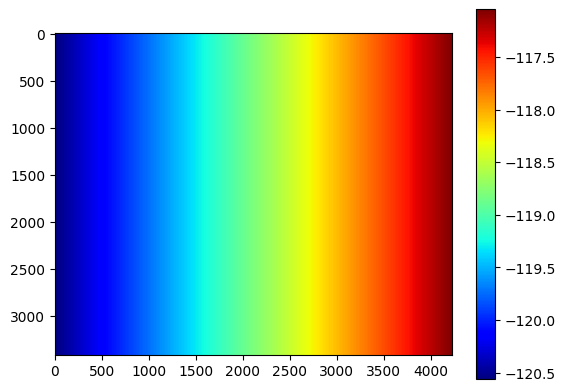

In [61]:
plt.imshow(loc[:,0].reshape((DEM.shape)), cmap='jet')
plt.colorbar()

In [46]:
hydro_interp_1, wet_interp_1, hydro_interp_2, wet_interp_2 = make_interpretor(WM1, 'hydro_total'), make_interpretor(WM1, 'wet_total'), make_interpretor(WM2, 'hydro_total'), make_interpretor(WM2, 'wet_total')
hydro_1, wet_1, hydro_2, wet_2 = hydro_interp_1(loc), wet_interp_1(loc), hydro_interp_2(loc), wet_interp_2(loc)
TD = (hydro_1 + wet_1) - (hydro_2 + wet_2)
HTD = hydro_1-hydro_2
TD = TD.reshape(DEM.shape)
HTD = HTD.reshape(DEM.shape)

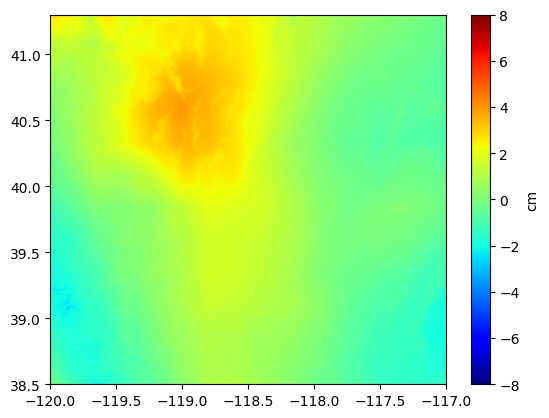

In [69]:
TD = TD.reshape(DEM.shape)
plt.imshow((TD - TD[2100, 3100])*100, cmap='jet',vmin=-8, vmax=8, extent=[-120, -117, 38.5, 41.3])
plt.colorbar(label='cm')
plt.show()

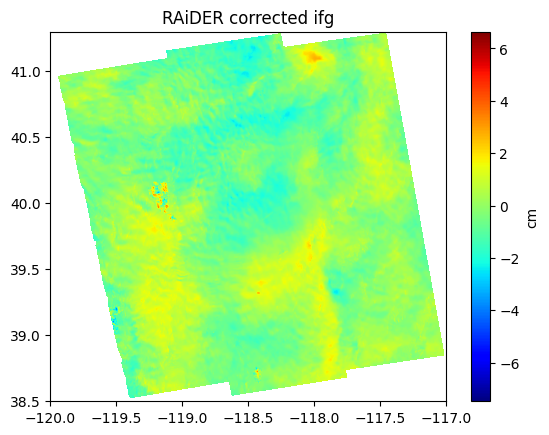

In [66]:
plt.imshow((ifg-ifg[2100, 3100])-((TD - TD[2100, 3100])*100), cmap='jet', extent=[-120, -117, 38.5, 41.3])
plt.colorbar(label='cm')
plt.title('RAiDER corrected ifg')
plt.show()

In [71]:
# Original ifg std
og_std = np.nanstd(ifg-ifg[2100, 3100])
# RAiDER corrected ifg std
raid_corr_std = np.nanstd((ifg-ifg[2100, 3100])-((TD - TD[2100, 3100])*100))
# Percentage chage
per_change = (raid_corr_std - og_std)/og_std
print('Metric compare')
print('Orgin ifg std: ', og_std)
print('Raider corrected ifg std: ', raid_corr_std)
print('Percentage change: ', per_change)

Metric compare
Orgin ifg std:  1.1567755
Raider corrected ifg std:  0.7877079686090845
Percentage change:  -0.31904852243116305
